In [ ]:
library(tidyverse)
library(mfbvar)
library(imputeTS)
library(Rmisc)

In [2]:
# helper function, generate lagged datasets for testing on vintages
gen_lagged_data <- function (metadata, data, last_date, lag) {
  # only go up to the last date
  lagged_data <- data %>% 
    dplyr::filter(date <= last_date)
  
  for (col in colnames(lagged_data)[2:length(colnames(lagged_data))]) {
    pub_lag <- metadata %>% 
      dplyr::filter(series == col) %>% 
      select(months_lag) %>% 
      pull()
    
    # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back)
    condition <- (nrow(lagged_data) - pub_lag + lag)
    # only input NA if the lag is less than the latest row in the data
    if (condition <= nrow(lagged_data)) {
      lagged_data[condition:nrow(lagged_data), col] <- NA
    } 
  }
  lagged_data <- lagged_data %>% 
    dplyr::filter(!is.na(date))
  return (lagged_data)
}

# Data set up

In [ ]:
# full data read
metadata <- read_csv("../data/meta_data.csv")
data <- read_csv("../data/data_tf.csv") %>%
  arrange(date)

target_variable <- "gdpc1"

# which lags to assess
lags <- -2:2

# dates for training and test
# test set is shorter in this example notebook than in the paper to save runtime. Set test_start_date to "2002-03-01" and test_end_date to "2022-09-01" for results of the paper.
train_start_date <- "1947-01-01"
test_start_date <- "2005-03-01"
test_end_date <- "2010-03-01"

# test datasets
test <- data %>%
    filter(date >= train_start_date, date <= test_end_date) %>% # let test set data begin from training begin, data lag/time series for test sets can go back into the training data
    data.frame()

# replace any infinites with NA
for (col in colnames(test)) {
    if (sum(is.infinite(test[,col])) > 0) {
      test[is.infinite(test[,col]), col] <- NA 
    }
}

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [4]:
tail(data)

date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,⋯,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea,gacdfsa066msfrbphi
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-08-01,0.001915508,NA,0.0011819650,0.002335260,0.18968692,0.006719933,0.05714286,0.09513435,-0.0006862216,⋯,0.005672678,0.005504572,0.002682399,-0.08486647,-0.002056898,0.009037228,NA,-0.013707165,NA,-1.5040650
2022-09-01,0.001761255,0.008011552,0.0038596847,0.002037679,-0.13467492,-0.001672780,-0.05405405,-0.02851459,0.0038251759,⋯,0.005758545,0.004644000,0.003443036,0.01426719,0.002560770,0.002484690,0.005911377,-0.009475679,0.002056349,-2.5967742
2022-10-01,0.001856197,NA,0.0043839992,0.007361543,0.08228980,0.013065747,0.05714286,-0.02116041,-0.0006249231,⋯,0.002715462,0.002616225,0.003729239,-0.03324808,-0.001788585,0.002912884,NA,-0.003826531,NA,-0.1212121
2022-11-01,0.001715758,NA,0.0009628869,-0.020892196,0.05785124,-0.005824232,0.00000000,-0.00488145,-0.0021948039,⋯,0.001986837,0.001680901,0.001043196,-0.10648148,-0.003270767,NA,NA,-0.002560819,NA,1.2298851
2022-12-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,-0.2886598
2023-01-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Training the model
Because of how Bayesian VAR models are estimated, similar to ARMA models, there is no model training set per se, the model is fitted and n-step ahead forecasts are generated at each data vintage in the testing set.

# Testing the model on artificial data vintages

In [5]:
# dates in the test set
dates <- seq(as.Date(test_start_date), as.Date(test_end_date), by="month") %>% 
      .[(substr(., 6, 7) %in% c("03", "06", "09", "12"))]

In [6]:
# dataframe for predictions
pred_dict <- data.frame(date = dates)
for (lag in lags) {
  pred_dict[,as.character(lag)] <- NA
}
# looping through test dates
for (date in as.character(dates)) {
  for (lag in lags) {
    lagged_data <- gen_lagged_data(metadata, test, date, lag) %>% 
      data.frame
    # make sure actual value not in there
    lagged_data[lagged_data$date == date, target_variable] <- NA
      
    # preserving NA structure at end, but filling earlier rows with mean to be able to estimate
    lagged_data[1:(round(nrow(lagged_data) * 0.9, 0)),] <- na_mean(lagged_data[1:(round(nrow(lagged_data) * 0.9, 0)),])
    lagged_data <- lagged_data[rowSums(is.na(lagged_data)) != ncol(lagged_data)-1, ] # drop end rows with only nas
    
    # converting to data format for mfbvar
    mf_test <- list()
    for (col in colnames(test)[2:length(colnames(test))]) {
        # get data frequency
        freq <- metadata %>% 
          filter(series == !!col) %>% 
          select(freq) %>% 
          pull()
        if (freq == "q") {
          freq <- 4
          tmp_series <- lagged_data %>% 
            filter(substr(date, 6, 7) %in% c("03", "06", "09", "12")) %>% 
            select(!!col) %>%
            slice(2:n()) %>% # first row is all NAs, so drop
            pull()
        } else {
          freq <- 12
          tmp_series <- lagged_data %>%
            select(!!col) %>% 
            slice(2:n()) %>%
            pull()
        }
        # convert data to correct time series format, set start date to correct start date of your data
        tmp_ts <- ts(tmp_series, start = c(1947,2), frequency = freq)
        mf_test[[col]] <- tmp_ts
    }
    
    # reorder the list to have quarterly variables, `ulcnfb` and `a261rx1q020sbea`, come last. Necessary for mfbvar library
    mf_test <- list(
        payems=mf_test$payems,
        cpiaucsl=mf_test$cpiaucsl,
        unrate=mf_test$unrate,
        houst=mf_test$houst,
        indpro=mf_test$indpro,
        dspic96=mf_test$dspic96,
        cpilfesl=mf_test$cpilfesl,
        pcepilfe=mf_test$pcepilfe,
        pcepi=mf_test$pcepi,
        permit=mf_test$permit,
        hsn1f=mf_test$hsn1f,
        ir=mf_test$ir,
        tcu=mf_test$tcu,
        iq=mf_test$iq,
        dgorder=mf_test$dgorder,
        rsafs=mf_test$rsafs,
        boptexp=mf_test$boptexp,
        boptimp=mf_test$boptimp,
        whlslrimsa=mf_test$whlslrimsa,
        ttlcons=mf_test$ttlcons,
        businv=mf_test$businv,
        ulcnfb=mf_test$ulcnfb,
        a261rx1q020sbea=mf_test$a261rx1q020sbea,
        gdpc1=mf_test$gdpc1
    )
      
    # actual bayesian var estimation
    prior <- set_prior(Y = mf_test, n_lags = 4, n_reps = 100)
    c_interval <- t(sapply(mf_test, CI, ci=0.95))
    prior_intervals <- c_interval[,c("upper","lower")]
    moments <- interval_to_moments(prior_intervals)
    prior <- update_prior(prior, d="intercept", prior_psi_mean = moments$prior_psi_mean,  prior_psi_Omega = moments$prior_psi_Omega)
    prior <- update_prior(prior, n_fcst = 12)

    model <- estimate_mfbvar(prior, prior = "minn", variance = "iw")

    prediction <- predict(model, pred_bands = NULL) %>% 
        filter(variable == target_variable, fcst_date == date) %>% 
        select(fcst) %>% 
        pull() %>% 
        mean()
    
    pred_dict[pred_dict$date == date, as.character(lag)] <- prediction
  }
}

# Assess and visualize model performance

In [7]:
actuals <- test %>%
    filter(date >= test_start_date) %>%
    select(!!target_variable) %>%
    filter(!is.na(!!sym(target_variable))) %>%
    pull()

In [8]:
performance <- data.frame(Vintage = numeric(), RMSE = numeric())
for (lag in lags) {
    tmp = data.frame(
        Vintage = lag,
        RMSE = sqrt(mean((actuals - pred_dict[,as.character(lag)])**2))
    )
    performance = rbind(performance, tmp)
}
round(performance, 4)

Vintage,RMSE
<dbl>,<dbl>
-2,0.0057
-1,0.0065
0,0.0047
1,0.0051
2,0.0051


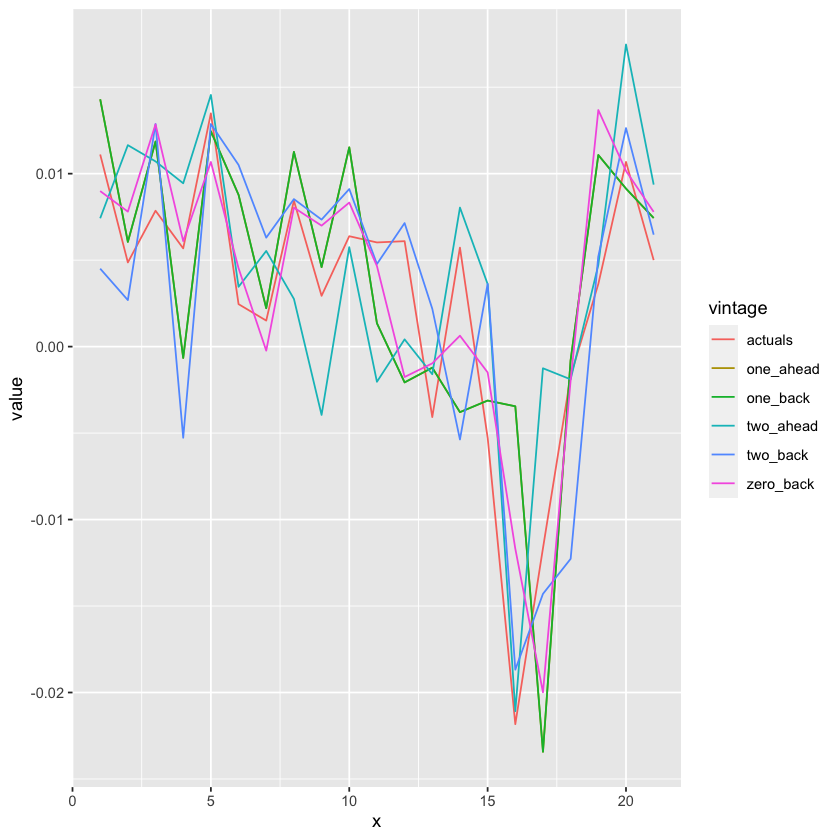

In [9]:
# plot of predictions vs actuals
p <- tibble(
    actuals = actuals,
    two_back = pred_dict[, "-2"], 
    one_back = pred_dict[, "-1"], 
    zero_back = pred_dict[, "0"],
    one_ahead = pred_dict[, "-1"],
    two_ahead = pred_dict[, "2"]
) %>%
    dplyr::mutate(x = 1:n()) %>%
    gather(vintage, value, -x) %>%
    ggplot() + 
    aes(x=x, y=value, color=vintage) + 
    geom_line()
p

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [12]:
# the test data ends 2010-03-01, let's say we wanted to predict 2010-06-01
new_data = test

# preserving NA structure at end, but filling earlier rows with mean to be able to estimate
new_data[1:(round(nrow(new_data) * 0.9, 0)),] <- na_mean(new_data[1:(round(nrow(new_data) * 0.9, 0)),])
new_data <- lagged_data[rowSums(is.na(new_data)) != ncol(new_data)-1, ] # drop end rows with only nas

# converting to data format for mfbvar
mf_test <- list()
for (col in colnames(new_data)[2:length(colnames(new_data))]) {
    # get data frequency
    freq <- metadata %>% 
      filter(series == !!col) %>% 
      select(freq) %>% 
      pull()
    if (freq == "q") {
      freq <- 4
      tmp_series <- new_data %>% 
        filter(substr(date, 6, 7) %in% c("03", "06", "09", "12")) %>% 
        select(!!col) %>%
        slice(2:n()) %>% # first row is all NAs, so drop
        pull()
    } else {
      freq <- 12
      tmp_series <- new_data %>%
        select(!!col) %>% 
        slice(2:n()) %>%
        pull()
    }
    # convert data to correct time series format, set start date to correct start date of your data
    tmp_ts <- ts(tmp_series, start = c(1947,2), frequency = freq)
    mf_test[[col]] <- tmp_ts
}

# reorder the list to have quarterly variables, `ulcnfb` and `a261rx1q020sbea`, come last. Necessary for mfbvar library
mf_test <- list(
  payems=mf_test$payems,
  cpiaucsl=mf_test$cpiaucsl,
  unrate=mf_test$unrate,
  houst=mf_test$houst,
  indpro=mf_test$indpro,
  dspic96=mf_test$dspic96,
  cpilfesl=mf_test$cpilfesl,
  pcepilfe=mf_test$pcepilfe,
  pcepi=mf_test$pcepi,
  permit=mf_test$permit,
  ulcnfb=mf_test$ulcnfb,
  a261rx1q020sbea=mf_test$a261rx1q020sbea,
  gdpc1=mf_test$gdpc1
)

In [13]:
# actual bayesian var estimation
prior <- set_prior(Y = mf_test, n_lags = 4, n_reps = 100)
c_interval <- t(sapply(mf_test, CI, ci=0.95))
prior_intervals <- c_interval[,c("upper","lower")]
moments <- interval_to_moments(prior_intervals)
prior <- update_prior(prior, d="intercept", prior_psi_mean = moments$prior_psi_mean,  prior_psi_Omega = moments$prior_psi_Omega)
prior <- update_prior(prior, n_fcst = 12)

model <- estimate_mfbvar(prior, prior = "minn", variance = "iw")

predict(model, pred_bands = NULL) %>% 
    filter(variable == target_variable, fcst_date == "2010-06-01") %>% 
    select(fcst) %>% 
    pull() %>% 
    mean()

[1] 0.01118469